<h1 align=center>AUC analysis</h1>

**This notebook is used for AUC analysis**

### import and function method

In [1]:
import torch, sys
sys.path.append('../')
import constants
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import os
from pathlib import Path
device = "cuda" if torch.cuda.is_available() else "cpu" 

/home_data/home/v-liudsh/miniconda3/envs/torch/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [26]:
def plot_roc_curve(y_true, y_pred_proba, title='Receiver Operating Characteristic (ROC) Curve', 
                  other = None, labels = None, save = None, box = False, plot=True, No = None):
    """
    绘制 ROC 曲线
    参数：
    - y_true: 实际标签
    - y_pred_proba: 预测概率
    - title: 图表标题
    - other: dict {configuration: ((label, predict))}

    返回：
    无，直接显示 ROC 曲线图表
    """
    roc_auc1 = 0
    roc_auc2 = 0
    roc_auc = 0
    # 计算 ROC 曲线的真正例率（tpr）、假正例率（fpr）以及 AUC
    if plot:
      plt.figure(figsize=(4, 4))
      plt.ylim(0,1)

    if other is not None:
      for config, values in other.items():
        label = values[0]
        predict = values[1] 
        fpr, tpr, thresholds = roc_curve(label, predict)
        roc_auc = auc(fpr, tpr)
        if No is not None:
          axs[No // 7, No % 7].plot(fpr, tpr, lw=2, label= config + ' (AUC = {:.4f})'.format(roc_auc))
          
        if plot:
          plt.plot(fpr, tpr, lw=2, label= config + ' (AUC = {:.4f})'.format(roc_auc))
    roc_auc1 = roc_auc

    fpr, tpr, thresholds = roc_curve(y_true, list(y_pred_proba))
    roc_auc = auc(fpr, tpr)
    roc_auc2 = roc_auc
    # print(title, roc_auc)

    # 绘制 ROC 曲线
    if plot and  box:
        text = plt.text(x=0.02,#文本x轴坐标 
          y=0.948, #文本y轴坐标
          s=title, #文本内容
          fontdict=dict(fontsize=20, color='r',family='monospace',),#字体属性字典
          #添加文字背景色
          bbox={'facecolor': '#F0C284', #填充色
                 'edgecolor':'b',#外框色
                'alpha': 0.5, #框透明度
                'pad': 8,#本文与框周围距离 
                },
          color = "#992224"
          )
    elif No is not None:
      text = axs[No // 7, No % 7].text(x=0.029,#文本x轴坐标 
      y=0.945, #文本y轴坐标
      s=title, #文本内容
      fontdict=dict(fontsize=18, color='r',family='monospace',),#字体属性字典
      #添加文字背景色
      bbox={'facecolor': '#F0C284', #填充色
              'edgecolor':'b',#外框色
            'alpha': 0.5, #框透明度
            'pad': 7,#本文与框周围距离 
            },
      color = "#992224"
      )
    elif plot:
        plt.title(title)
      # text_box_props = dict(boxstyle='round', facecolor='lightblue', alpha=0.5)
      # plt.text(x=20, y=5, s=title, bbox=text_box_props, fontsize=12, color='darkblue', ha='center')

      # plt.text(x=6000, y=0.4, s=title, bbox=dict(facecolor='red', alpha=0.5))
    if labels is not None:
      if plot:
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=labels + ' (AUC = {:.4f})'.format(roc_auc))
      if No is not None:
          axs[No // 7, No % 7].plot(fpr, tpr, lw=2, label= labels + ' (AUC = {:.4f})'.format(roc_auc))
          # ax.legend()
          # ax.grid(True)
    else:
      if plot:
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=' (AUC = {:.4f})'.format(roc_auc))
    if plot:
      plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
      plt.xlim([0.0, 1.0])
      plt.ylim([0.0, 1.0])
      plt.xlabel('False Positive Rate (FPR)')
      plt.ylabel('True Positive Rate (TPR)')

      plt.legend(loc='lower right', fontsize='14')
      plt.grid(True)
    if No is not None:
      axs[No // 7, No % 7].grid(True)
      axs[No // 7, No % 7].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
      axs[No // 7, No % 7].set_xlim([0.0, 1.0])
      axs[No // 7, No % 7].set_ylim([0.0, 1.0])
      axs[No // 7, No % 7].set_xlabel('False Positive Rate (FPR)')
      axs[No // 7, No % 7].set_ylabel('True Positive Rate (TPR)')
      axs[No // 7, No % 7].legend(loc='lower right', fontsize='10')
    if save is not None:
      plt.savefig(f'{save}/{title}.png', format='png')
    return roc_auc1, roc_auc2
  

# 示例用法
# 假设 y_true 和 y_pred_proba 是你的标签和预测概率
# plot_roc_curve(y_true, y_pred_proba)


def print_roc( plot=True, record_roc = False, training_step = 0, 
               data = None, save = None, box = False):
  """
  for each label(disease) gets its own auc
  plot: bool, whether plot the roc plot in this function
  return auc value 
  """
  
  disease_auc = {}
  label_dis1 = None
  diff = []
  avg_auc_1 = []
  avg_auc_2 = []
  for i, disease in enumerate(constants.CHEXPERT_LABELS):
    # print(data.values)
    config = list(data.keys())[0]
    config1 = list(data.keys())[1]
    label_dis = list(data.values())[0]["labels"]
    label_dis =  label_dis[:, i]
    label_dis1 =  list(data.values())[1]["labels"]
    label_dis1 = label_dis1[:, i]
    predictions_tensor = list(data.values())[0]["predict"]
    predictions_tensor_1 = list(data.values())[1]["predict"]

    each_class_roc = {}

    for k, j in enumerate(constants.class_name):
      if j != "positive": ## negative, uncertain
        continue

      pred_dis = predictions_tensor[:, i*len(constants.class_name) + k].cpu().numpy()
      pred_dis_1 = predictions_tensor_1[:, i*len(constants.class_name) + k].cpu().numpy()

      true_class = [1 if constants.class_name[j] == y else 0 for y in label_dis]
      true_class_1 = [1 if constants.class_name[j] == y else 0 for y in label_dis1]
      assert true_class == true_class_1
      if(len(set(true_class))==1):
        print(constants.RED, "this disease have something wrong: "+constants.RESET, disease, ", ", j, "in this case set auc is 0!!!")
        each_class_roc[j] = 0
        continue
      title = f"{disease}"
      item = list(data.keys())
      if predictions_tensor_1 is not None:
        other = {item[1]: (true_class_1, pred_dis_1)}
        roc_auc1, roc_auc2 = plot_roc_curve( true_class, pred_dis,plot = plot, title = title , other = other, labels = item[0],
                                            save = save, box = box, No = i)

      else:
        roc_auc1, roc_auc2 = plot_roc_curve( true_class, pred_dis,plot = plot, title = title, labels = item[0],save = save, box = box)

    #   each_class_roc[j] = roc_auc_score(true_class, pred_dis, multi_class="ovr", average="micro",)
    # disease_auc[disease] = each_class_roc 
      each_diff = roc_auc1 - roc_auc2
      diff.append(each_diff)
      avg_auc_1.append(roc_auc1)
      avg_auc_2.append(roc_auc2)
  if plot:
    plt.show()
  print(diff)
  print(f"{config1} V.S. {config} \n({config1}) - ({config})\ntotal diff: {sum(diff)} \navg diff:  {sum(diff)/len(diff)}")
  print(f"{config1} average auc = {sum(avg_auc_1)/len(avg_auc_1)}")
  print(f"{config} average auc = {sum(avg_auc_2)/len(avg_auc_2)}")
  return roc_auc1, roc_auc2, diff

### load data

In [4]:
bio_high_task = r"..\output\dump_prediction_output\biomedclip_None_False_False_binary_False_False_task_balance\tensor.pth"
bio_high_task_f = r"..\output\dump_prediction_output\biomedclip_None_False_False_binary_False_False_task_balance_final\tensor.pth"
bio_high_no_contrastive_task = r"..\output\dump_prediction_output\biomedclip_None_False_False_binary_False_True_task_balance\tensor.pth"
bio_high_no_contrastive_task_f = r"..\output\dump_prediction_output\biomedclip_None_False_False_binary_False_True_task_balance_final\tensor.pth"
bio_high_no_ortho_task = r"..\output\dump_prediction_output\biomedclip_None_False_False_binary_True_False_task_balance\tensor.pth"
bio_high_no_ortho_task_f = r"..\output\dump_prediction_output\biomedclip_None_False_False_binary_True_False_task_balance_final\tensor.pth"
bio_orth_task = r"..\output\dump_prediction_output\biomedclip_None_False_False_NA_False_False_task_balance\tensor.pth"
bio_orth_f = r"..\output\dump_prediction_output\biomedclip_None_False_False_NA_False_False_task_balance_final\tensor.pth"
bio_v = r"..\output\dump_prediction_output\biomedclip_None_True_False_NA_False_False_NA\tensor.pth"
bio_v_f = r"..\output\dump_prediction_output\biomedclip_None_True_False_NA_False_False_NA_final\tensor.pth"
bio_grapg_NoOrth_NoContrastive = r"..\output\dump_prediction_output\biomedclip_None_False_False_binary_True_True_task_balance\tensor.pth"
bio_grapg_NoOrth_NoContrastive_f = r"..\output\dump_prediction_output\biomedclip_None_False_False_binary_True_True_task_balance_final\tensor.pth"
clip_grapg_NoOrth_NoContrastive = r"..\output\dump_prediction_output\clip_None_False_False_binary_True_True_task_balance\tensor.pth"
clip_grapg_NoOrth_NoContrastive_f = r"..\output\dump_prediction_output\clip_None_False_False_binary_True_True_task_balance_final\tensor.pth"

clip_grapg_NoOrth_NoContrastive = torch.load(clip_grapg_NoOrth_NoContrastive, map_location=torch.device(device))
clip_grapg_NoOrth_NoContrastive_f = torch.load(clip_grapg_NoOrth_NoContrastive_f, map_location=torch.device(device))

bio_grapg_NoOrth_NoContrastive = torch.load(bio_grapg_NoOrth_NoContrastive, map_location=torch.device(device))
bio_grapg_NoOrth_NoContrastive_f = torch.load(bio_grapg_NoOrth_NoContrastive_f, map_location=torch.device(device))
bio_high_task = torch.load(bio_high_task, map_location=torch.device(device))
bio_high_task_f = torch.load(bio_high_task_f, map_location=torch.device(device))
bio_high_no_contrastive_task = torch.load(bio_high_no_contrastive_task, map_location=torch.device(device))
bio_high_no_contrastive_task_f = torch.load(bio_high_no_contrastive_task_f, map_location=torch.device(device))
bio_high_no_ortho_task = torch.load(bio_high_no_ortho_task, map_location=torch.device(device))
bio_high_no_ortho_task_f = torch.load(bio_high_no_ortho_task_f, map_location=torch.device(device))
bio_orth_task = torch.load(bio_orth_task, map_location=torch.device(device))
bio_orth_f = torch.load(bio_orth_f, map_location=torch.device(device))
bio_v = torch.load(bio_v, map_location=torch.device(device))
bio_v_f = torch.load(bio_v_f, map_location=torch.device(device))



FileNotFoundError: [Errno 2] No such file or directory: '..\\output\\dump_prediction_output\\clip_None_False_False_binary_True_True_task_balance\\tensor.pth'

In [32]:
biovil_all_loss = r"/home_data/home/v-liudsh/coding/constrastive_P/diagnosisP/exchange/Fine-Grained_Features_Alignment_via_Constrastive_Learning/src/output/dump_prediction_output/biovil-t_None_False_False_binary_False_False_NA/tensor.pth"
biovil_all_loss_f = r"/home_data/home/v-liudsh/coding/constrastive_P/diagnosisP/exchange/Fine-Grained_Features_Alignment_via_Constrastive_Learning/src/output/dump_prediction_output/biovil-t_None_False_False_binary_False_False_NA_final/tensor.pth"
biovil_all_loss = torch.load(biovil_all_loss, map_location=torch.device(device))
biovil_all_loss_f = torch.load(biovil_all_loss_f, map_location=torch.device(device))

biovil_v = r"/home_data/home/v-liudsh/coding/constrastive_P/diagnosisP/exchange/Fine-Grained_Features_Alignment_via_Constrastive_Learning/src/output/dump_prediction_output/biovil-t_None_True_False_binary_False_False_NA/tensor.pth"
biovil_v_f = r"/home_data/home/v-liudsh/coding/constrastive_P/diagnosisP/exchange/Fine-Grained_Features_Alignment_via_Constrastive_Learning/src/output/dump_prediction_output/biovil-t_None_True_False_binary_False_False_NA_final/tensor.pth"
biovil_v = torch.load(biovil_v, map_location=torch.device(device))
biovil_v_f = torch.load(biovil_v_f, map_location=torch.device(device))

biovil_graph_only = r"/home_data/home/v-liudsh/coding/constrastive_P/diagnosisP/exchange/Fine-Grained_Features_Alignment_via_Constrastive_Learning/src/output/dump_prediction_output/biovil-t_None_False_False_binary_True_True_NA/tensor.pth"
biovil_graph_only_f = r"/home_data/home/v-liudsh/coding/constrastive_P/diagnosisP/exchange/Fine-Grained_Features_Alignment_via_Constrastive_Learning/src/output/dump_prediction_output/biovil-t_None_False_False_binary_True_True_NA_final/tensor.pth"
biovil_graph_only = torch.load(biovil_graph_only, map_location=torch.device(device))
biovil_graph_only_f = torch.load(biovil_graph_only_f, map_location=torch.device(device))



### plot

##### different config with vision_only baseline

<body>
	<p align="center">BiomedCLIP</p>
</body>

BiomedCLIP + Vision_only V.S. BiomedCLIP + Orth. + Graph 
(BiomedCLIP + Vision_only) - (BiomedCLIP + Orth. + Graph)
total diff: -0.01954963765733575 
avg diff:  -0.0013964026898096965


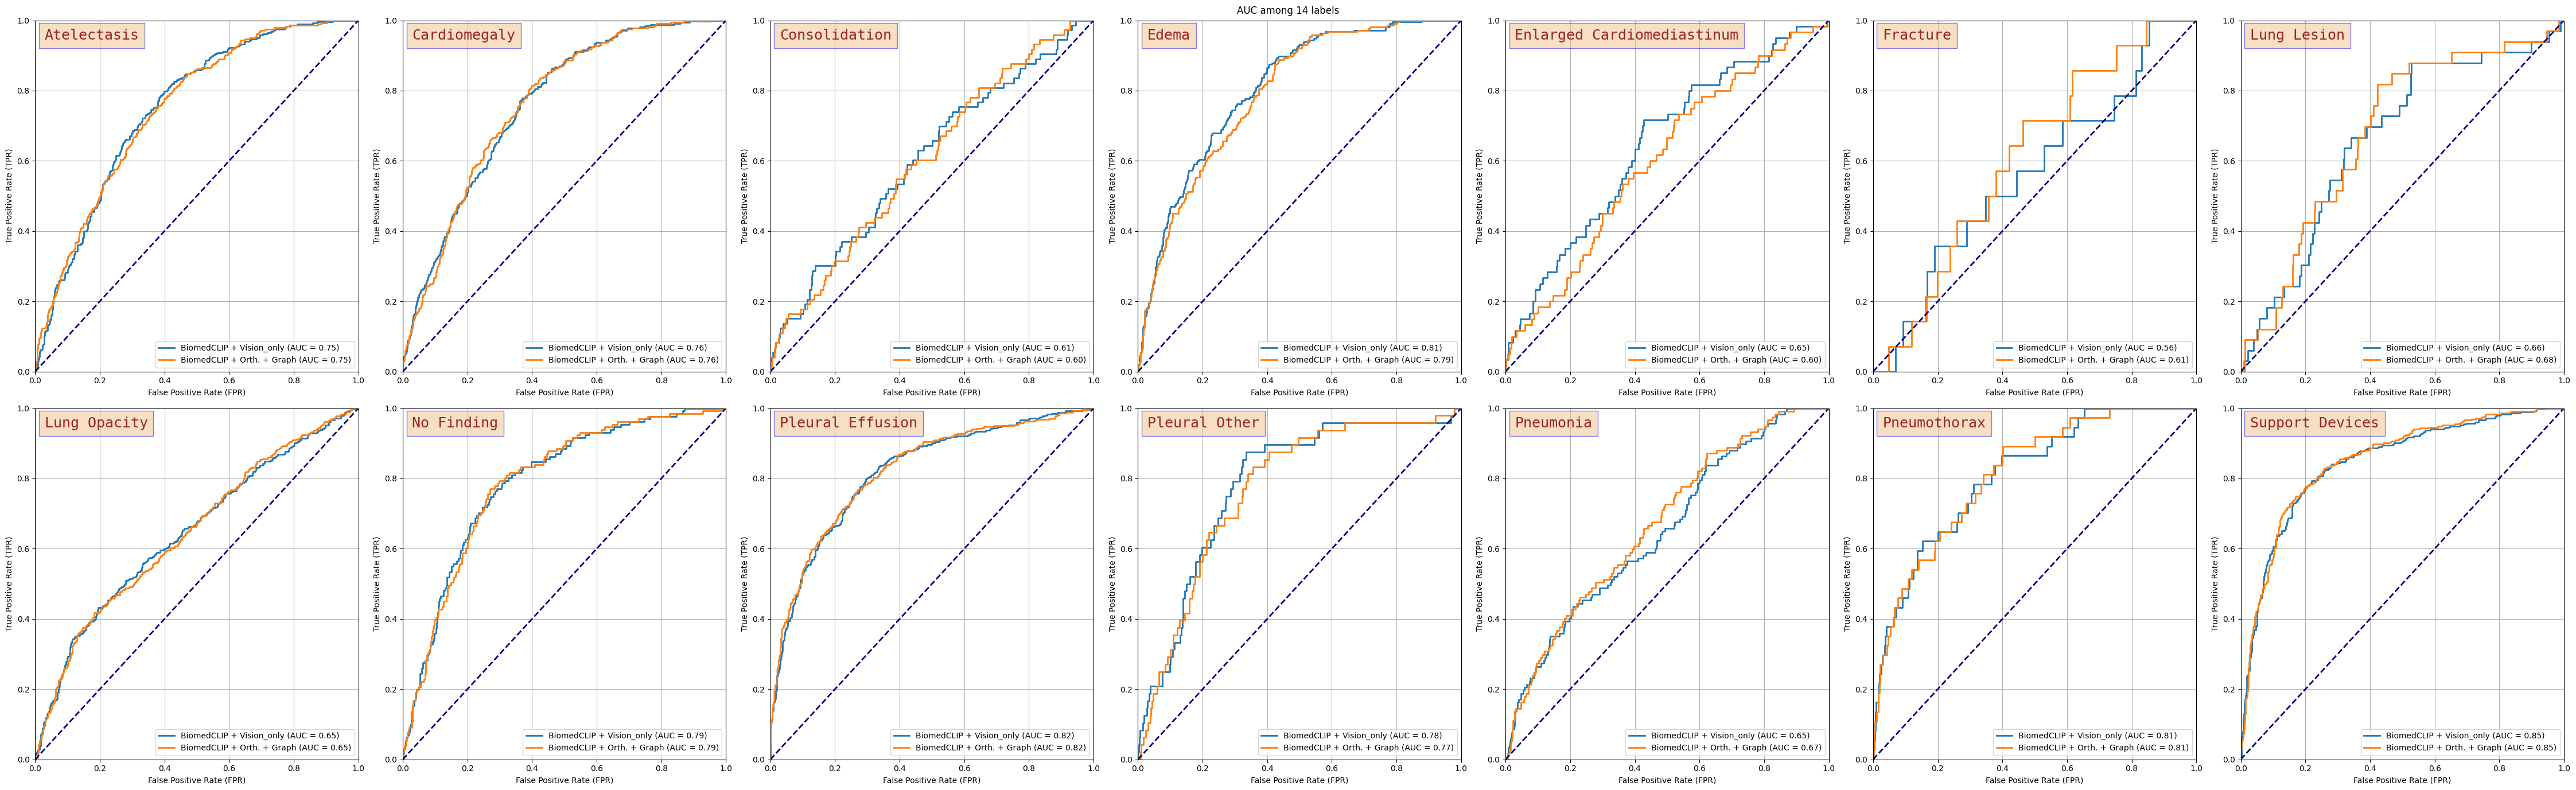

In [227]:
data = { "BiomedCLIP + Orth. + Graph":{'predict': bio_high_task["predictions"], 'labels':bio_high_task["labels"]},
        "BiomedCLIP + Vision_only":{"predict":bio_v["predictions"], "labels": bio_v["labels"]}

}
fig, axs = plt.subplots(2, 7, figsize=(45, 14))
_,_, diff = print_roc(
          data = data , box = True, plot=False)
plt.suptitle('AUC among 14 labels')

# 调整布局，防止子图重叠
plt.tight_layout()

# 显示图形
plt.show()

<font type=Sylfaen color=#C3A060>using orth + graph can improve AUC performance compared with the vision only counterpart</font><br>
<font color=#e27055> orth + graph can improve the performance in the poor class in the original version only version<br>
(orth + graph) - vision_only = 1.9 </font><br>

BiomedCLIP + Vision_only V.S. BiomedCLIP + Orth. 
(BiomedCLIP + Vision_only) - (BiomedCLIP + Orth.)
total diff: -0.009866260081900502 
avg diff:  -0.000704732862992893


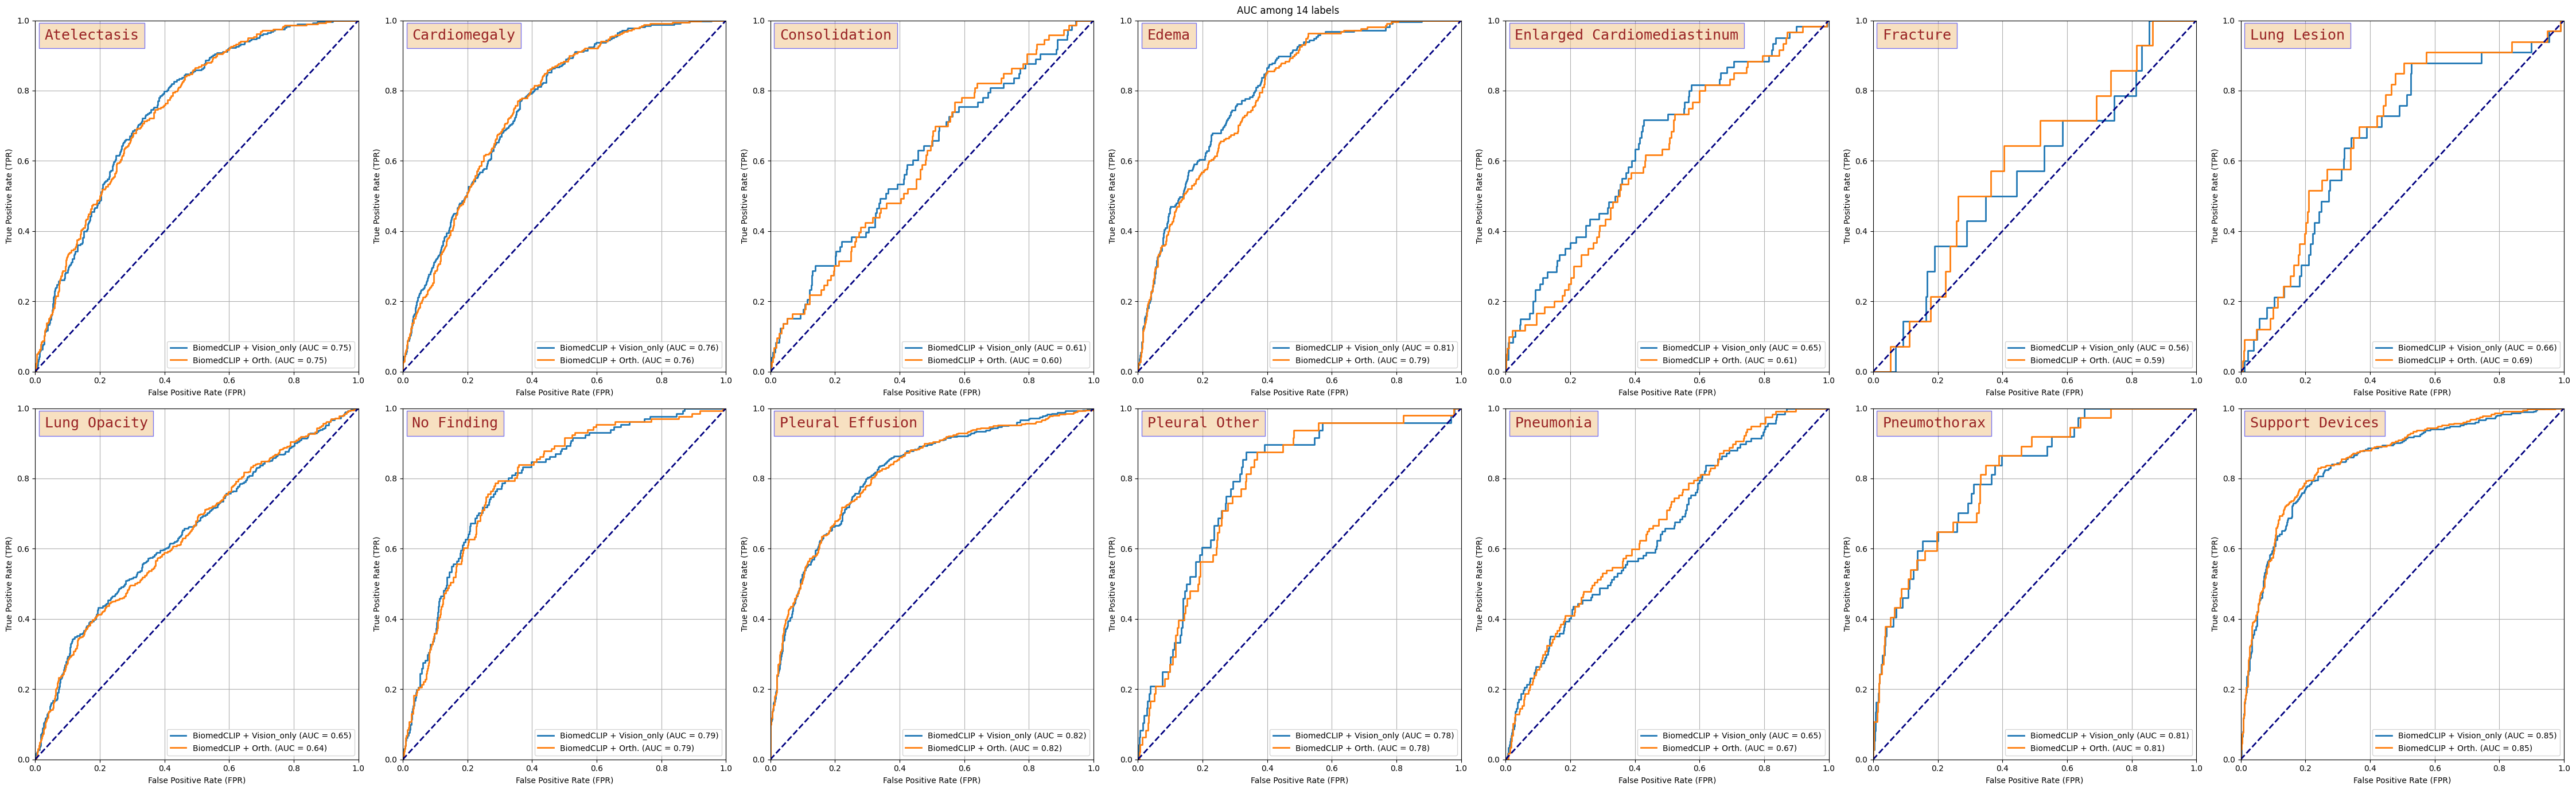

In [228]:
data = { "BiomedCLIP + Orth.":{'predict': bio_orth_task["predictions"], 'labels':bio_orth_task["labels"]},
        "BiomedCLIP + Vision_only":{"predict":bio_v["predictions"], "labels": bio_v["labels"]}

}
fig, axs = plt.subplots(2, 7, figsize=(45, 14))
_,_, diff = print_roc(
          data = data , box = True, plot=False)
plt.suptitle('AUC among 14 labels')

# 调整布局，防止子图重叠
plt.tight_layout()

# 显示图形
plt.show()

<font type=Sylfaen color=#C3A060>using orth can improve AUC performance compared with the vision only counterpart</font><br>
<font color=#e27055>
orth - vision_only = 0.9 </font><br>

BiomedCLIP + Vision_only V.S. BiomedCLIP + graph. 
(BiomedCLIP + Vision_only) - (BiomedCLIP + graph.)
total diff: -0.030539265053223907 
avg diff:  -0.002181376075230279


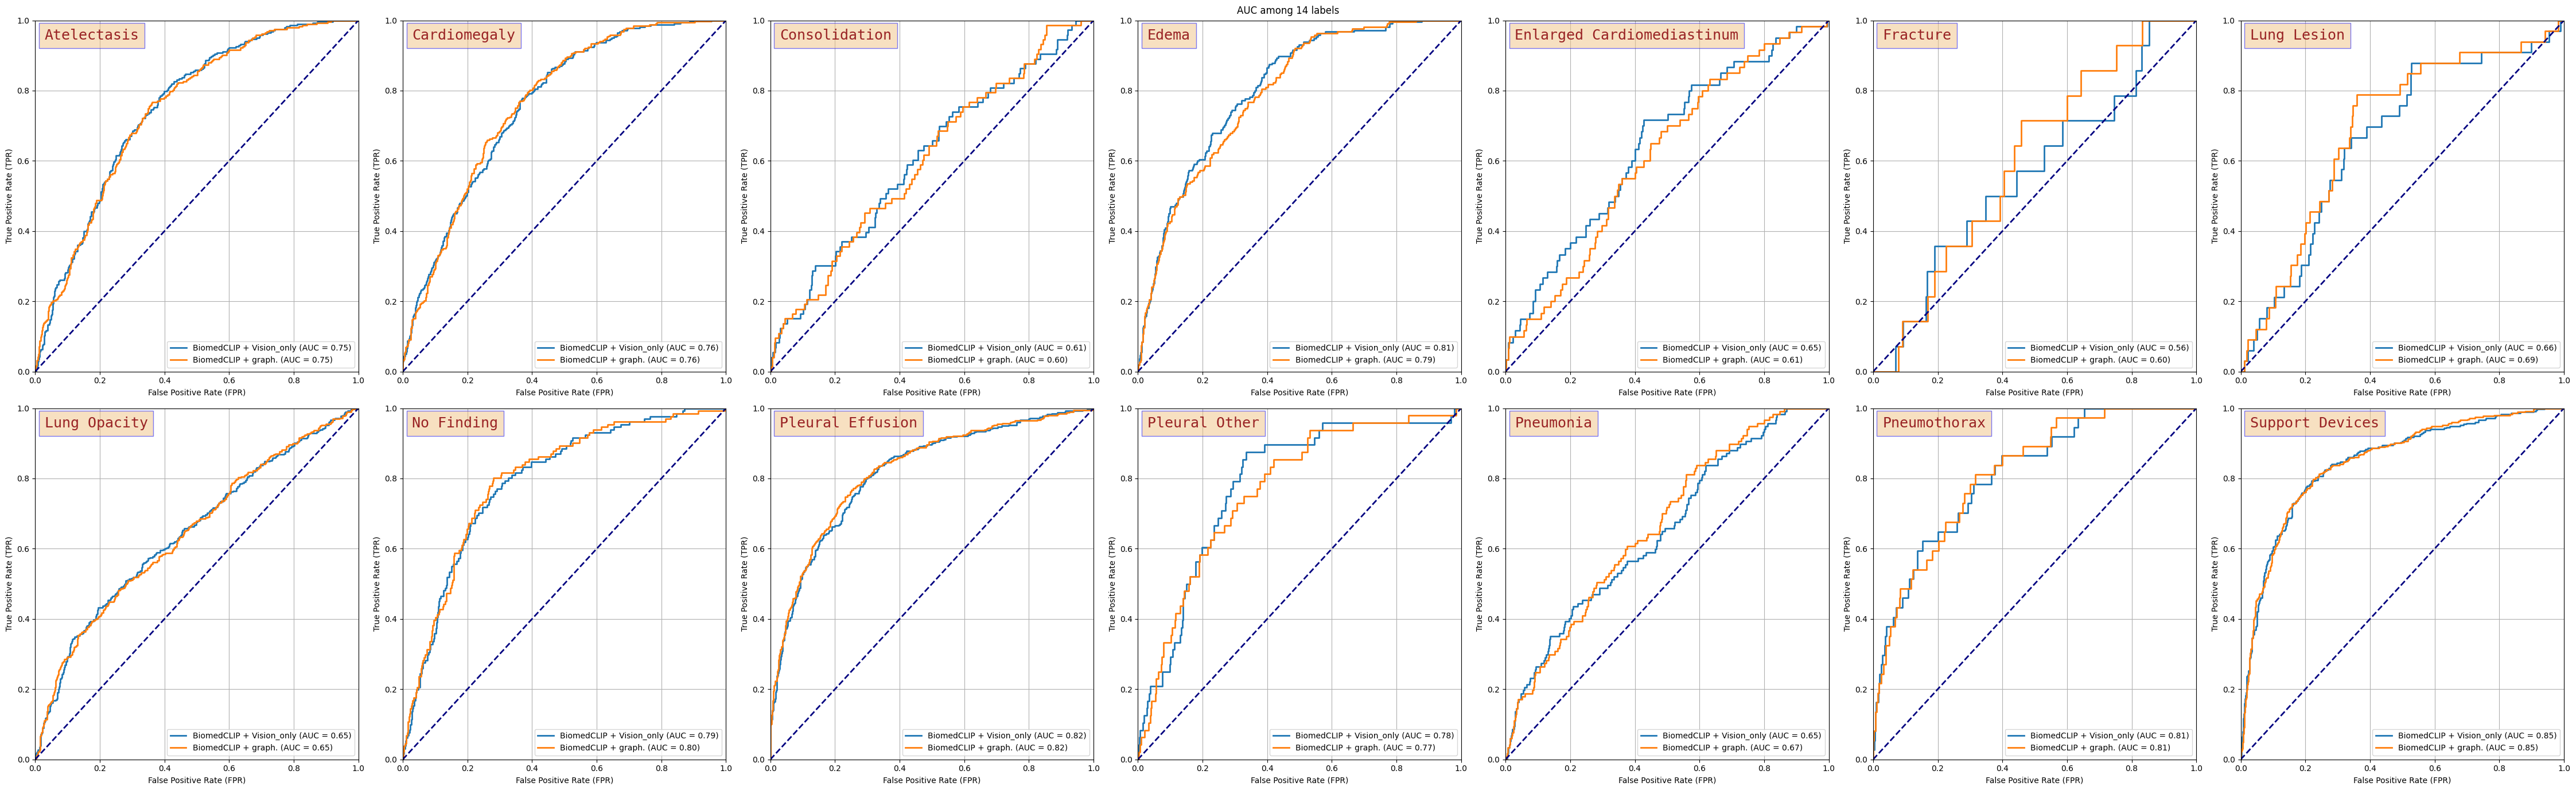

In [229]:
data = { "BiomedCLIP + graph.":{'predict': bio_high_no_ortho_task["predictions"], 'labels':bio_high_no_ortho_task["labels"]},
        "BiomedCLIP + Vision_only":{"predict":bio_v["predictions"], "labels": bio_v["labels"]}

}
fig, axs = plt.subplots(2, 7, figsize=(45, 14))
_,_, diff = print_roc(
          data = data , box = True, plot=False)

plt.suptitle('AUC among 14 labels')

# 调整布局，防止子图重叠
plt.tight_layout()

# 显示图形
plt.show()

<font type=Sylfaen color=#C3A060>using graph can improve AUC performance compared with the vision only counterpart</font><br>
<font color=#e27055>
graph - vision_only = 3 </font><br>

[0.005435040960877102, -0.0011066746082519785, -0.010143450264773923, 0.012199612403100857, 0.00977578475336327, -0.010028300725975159, -0.017990765801623843, -0.0019409282700422192, 0.00132344769091286, -0.0018987341772152, 0.004843241644483798, -0.018136138173945326, -0.0007599867002326954, -0.005416022313045388]
BiomedCLIP + Vision_only V.S. BiomedCLIP + graph + orth + no_contrastive. 
(BiomedCLIP + Vision_only) - (BiomedCLIP + graph + orth + no_contrastive.)
total diff: -0.033843873582367845 
avg diff:  -0.0024174195415977034


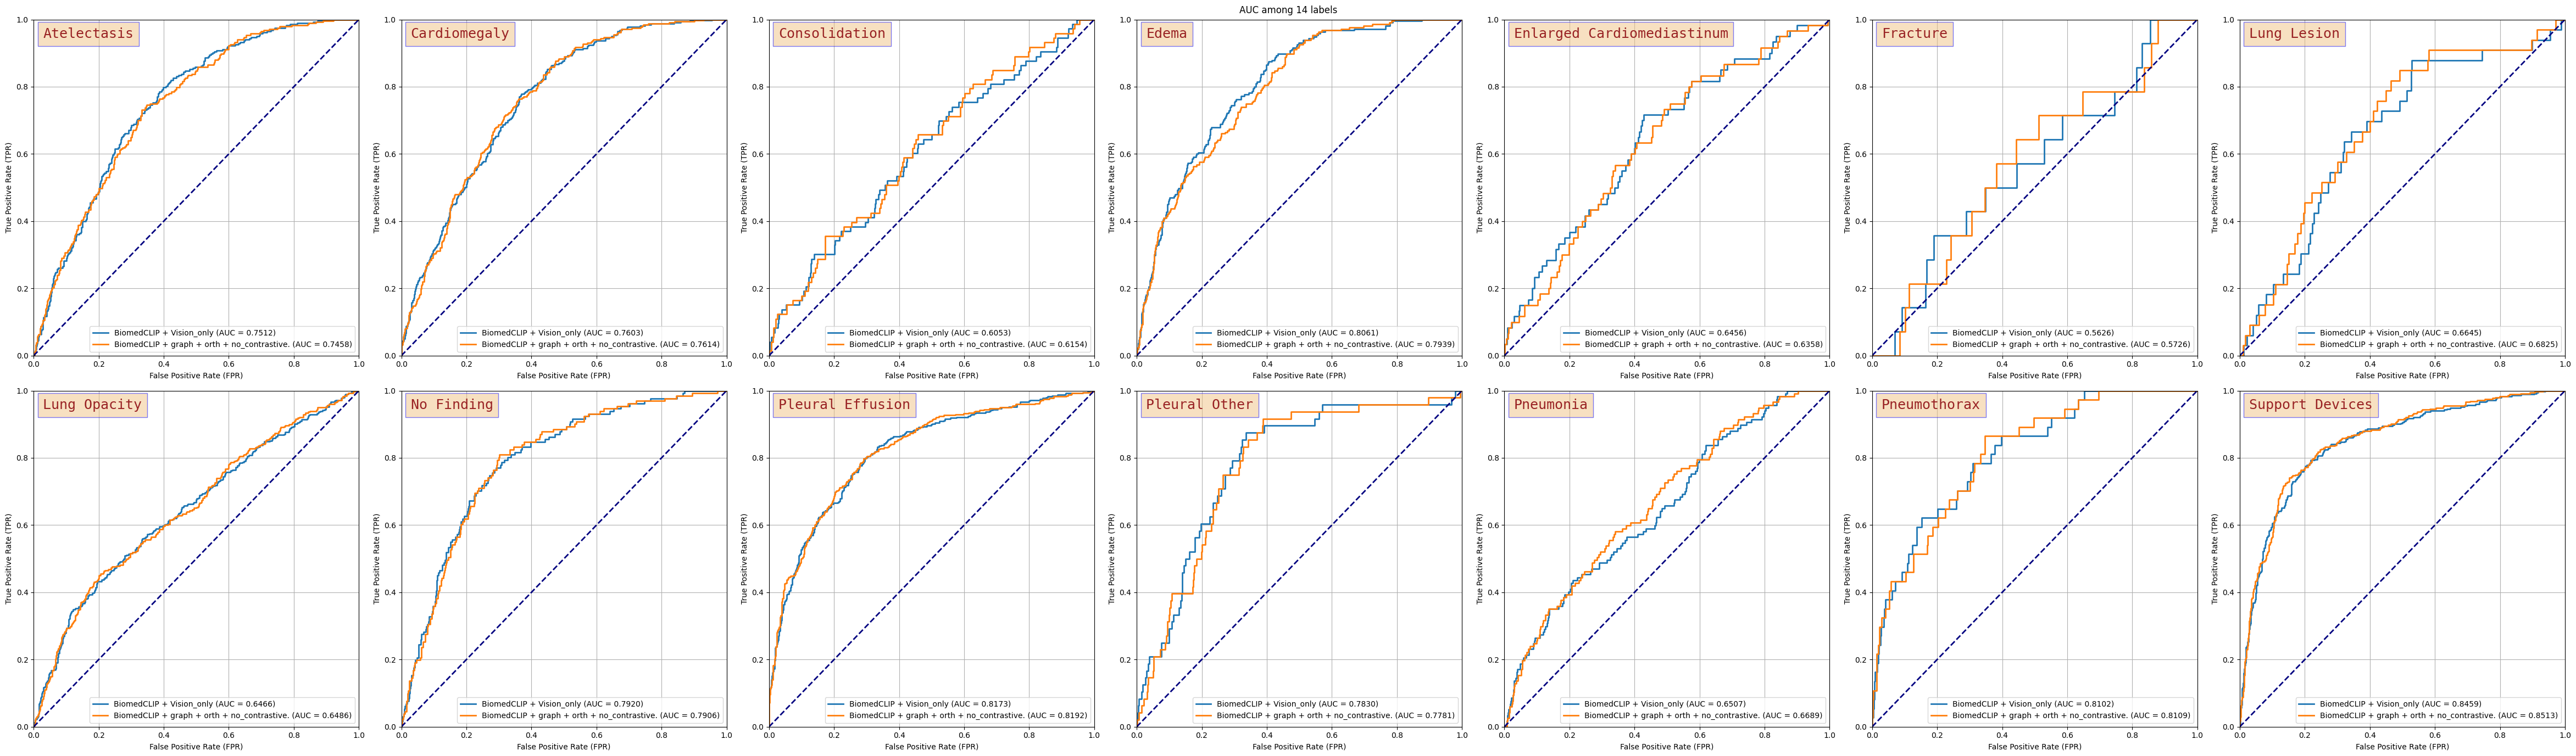

In [243]:
data = { "BiomedCLIP + graph + orth + no_contrastive.":{'predict': bio_high_no_contrastive_task["predictions"], 'labels':bio_high_no_contrastive_task["labels"]},
        "BiomedCLIP + Vision_only":{"predict":bio_v["predictions"], "labels": bio_v["labels"]}

}
fig, axs = plt.subplots(2, 7, figsize=(47, 14))
_,_, diff = print_roc(
          data = data , box = True, plot=False)

plt.suptitle('AUC among 14 labels')
plt.tight_layout()
plt.show()

<font type=Sylfaen color=#C3A060>using orth + graph + no_contrastive can improve AUC performance compared with the vision only counterpart</font><br>
<font color=#e27055>
(orth + graph + no_contrastive) - vision_only = 3.38 </font><br>

ToDo  
<input type=checkbox checked> auc comparison between vision_only and graph+NoContrastive configuration 

[0.002872015085011448, -0.004331105277477709, 0.0028590607363946363, 0.011187015503876019, 0.010358744394618702, -0.041897379106681454, -0.023271241309770097, 0.0050438169425511825, 0.009424994881694015, -0.0029438493995457282, 0.010333481218574136, -0.023419449695442074, -0.010426067543817918, -0.008733292831105688]
BiomedCLIP + Vision_only V.S. BiomedCLIP + graph + no_orth_contrastive. 
(BiomedCLIP + Vision_only) - (BiomedCLIP + graph + no_orth_contrastive.)
total diff: -0.06294325640112053 
avg diff:  -0.004495946885794323


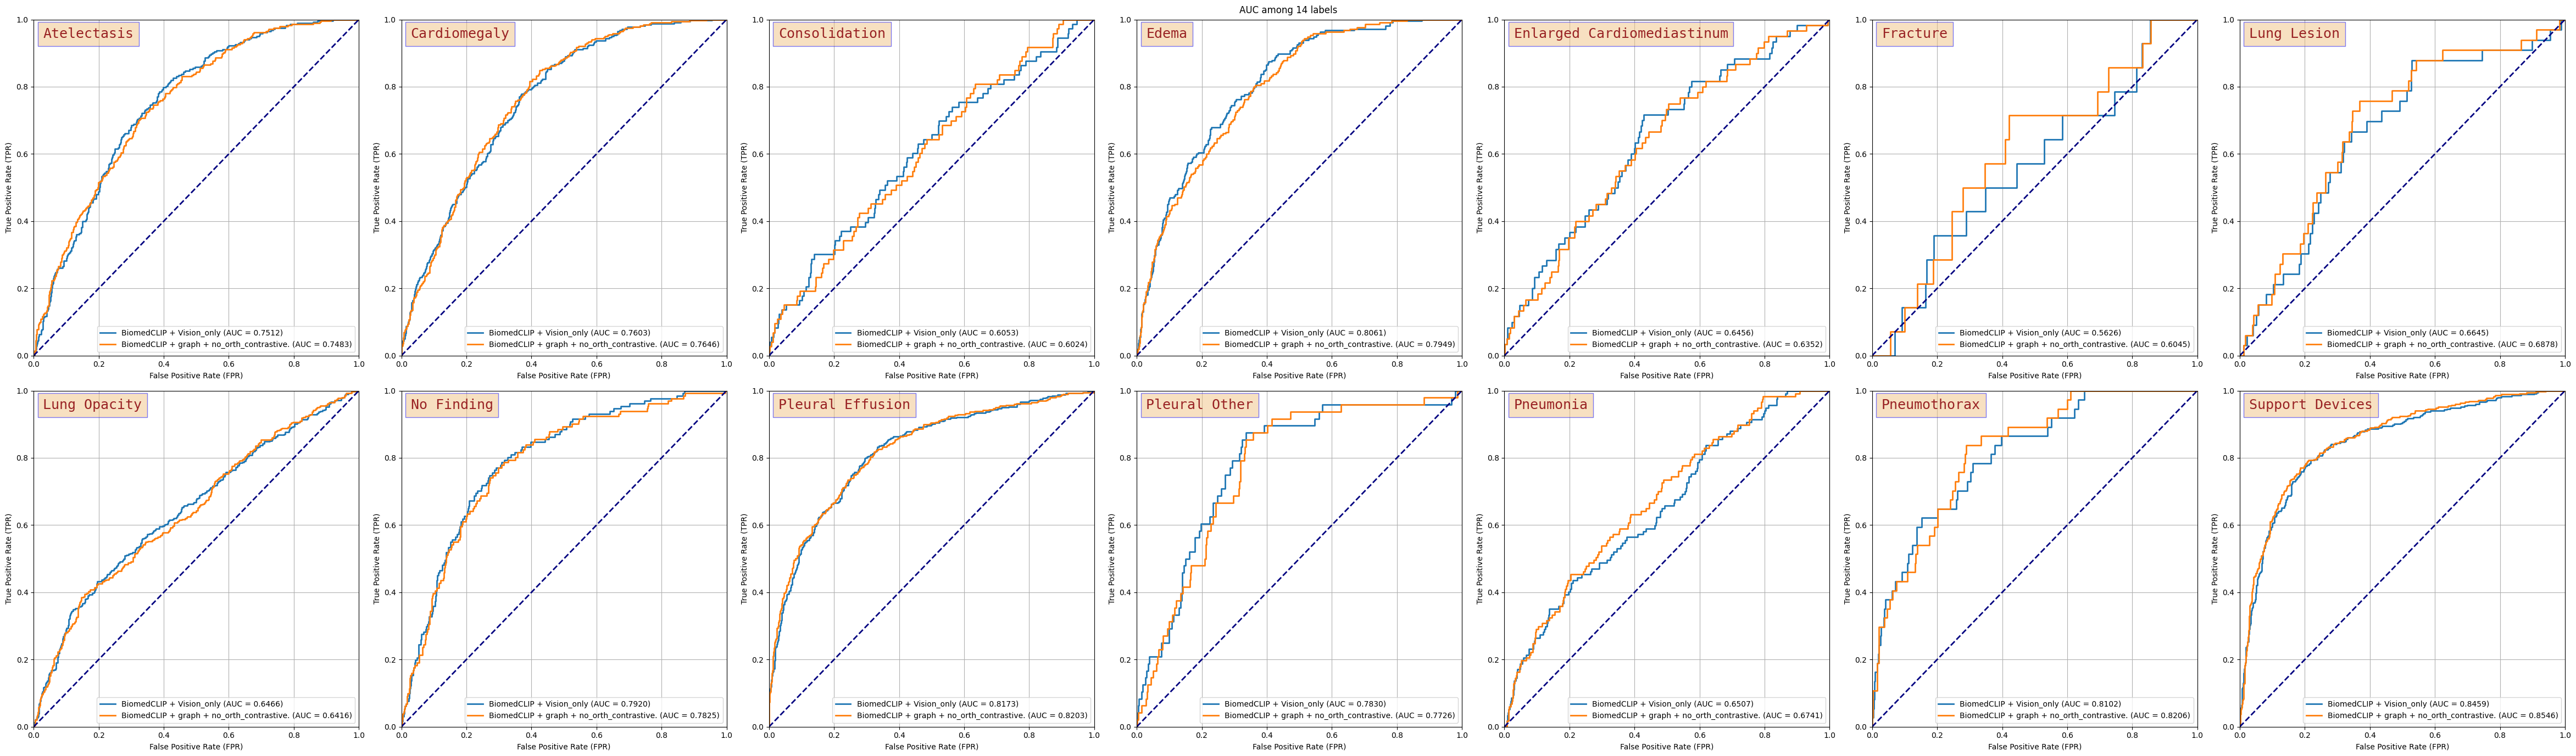

In [244]:
data = { "BiomedCLIP + graph + no_orth_contrastive.":{'predict': bio_grapg_NoOrth_NoContrastive["predictions"], 'labels':bio_grapg_NoOrth_NoContrastive["labels"]},
        "BiomedCLIP + Vision_only":{"predict":bio_v["predictions"], "labels": bio_v["labels"]}

}
fig, axs = plt.subplots(2, 7, figsize=(47, 14))
_,_, diff = print_roc(
          data = data , box = True, plot=False)

plt.suptitle('AUC among 14 labels')
plt.tight_layout()
plt.show()

<font type=Sylfaen color=#C3A060>using graph + no_orth_contrastive can improve AUC performance compared with the vision only counterpart</font><br>
<font color=#e27055>
(graph + no_orth_contrastive) - vision_only = 6.29 </font><br>

----
<body>
	<p align="center">BiomedCLIP VS CLIP</p>
</body>
the initial comparison between `BiomedCLIP_vision` with `CLIP + graph + no_orth_contrastive`   
`BiomedCLIP_vision` is better than `CLIP + graph + no_orth_contrastive` 



[0.04254147585922752, 0.06418345061878172, 0.025656962434427943, 0.04104651162790707, 0.050313901345291345, 0.042143472376030555, 0.04343788144138416, 0.04890295358649788, 0.021292152905735384, 0.052372606296656854, 0.11488834664300496, 0.0949461166852471, 0.004583669785778843, 0.02273072462167236]
BiomedCLIP + Vision_only V.S. CLIP + graph + no_orth_contrastive. 
(BiomedCLIP + Vision_only) - (CLIP + graph + no_orth_contrastive.)
total diff: 0.6690402262276437 
avg diff:  0.047788587587688836


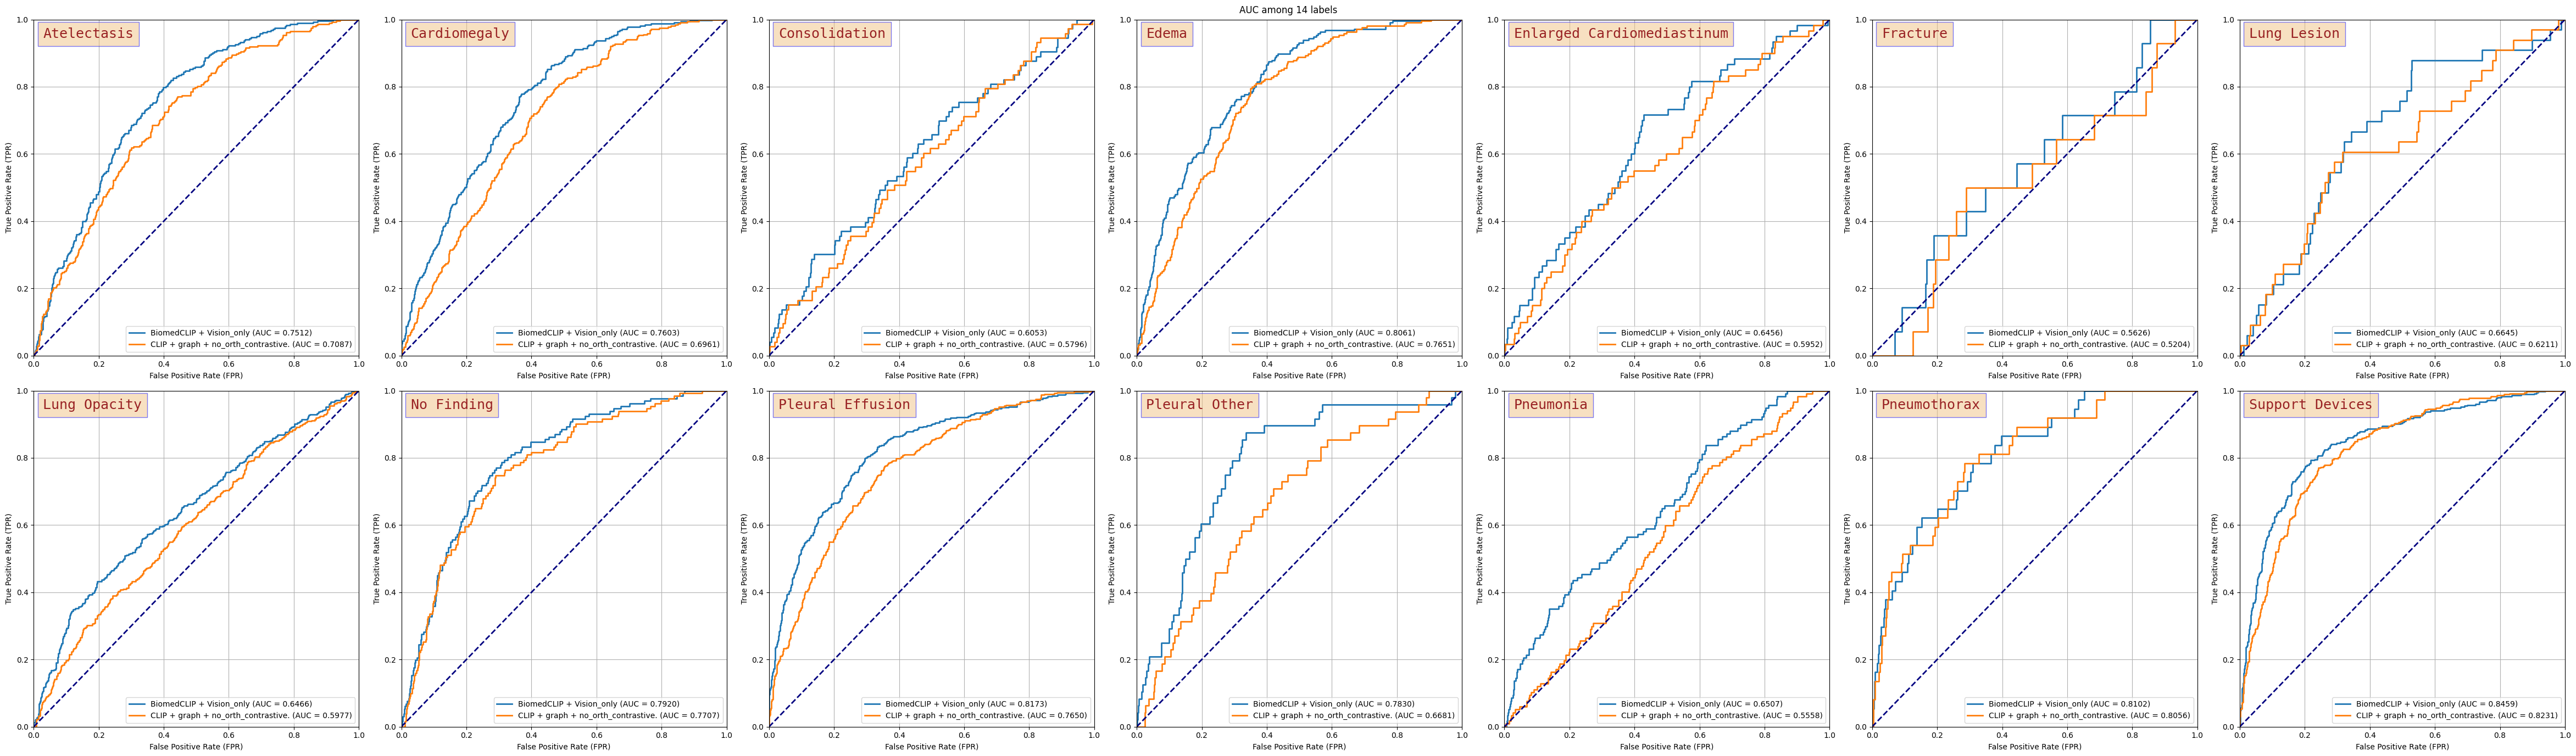

In [12]:
data = { "CLIP + graph + no_orth_contrastive.":{'predict': clip_grapg_NoOrth_NoContrastive["predictions"], 'labels':clip_grapg_NoOrth_NoContrastive["labels"]},
        "BiomedCLIP + Vision_only":{"predict":bio_v["predictions"], "labels": bio_v["labels"]}

}
fig, axs = plt.subplots(2, 7, figsize=(47, 14))
_,_, diff = print_roc(
          data = data , box = True, plot=False)

plt.suptitle('AUC among 14 labels')
plt.tight_layout()
plt.show()

-----

<body>
	<p align="center">Biovil-T</p>
</body>

<b>biovil_t_all_loss <font color=red>VS</font> biovil_t_all_loss_final</b>

[0.00014657180433863548, -7.353319656167034e-05, 0.005481938194565328, -0.0025775193798447393, -0.0013602391629298216, -0.0061523317337270345, 0.003582232128641949, 0.0028627069133397853, 0.002507969933608356, 0.0015546900357026328, 0.005342354333037647, 0.006777826248525631, 0.0015437229848476175, -0.0015084778526455178]
biovil_all_loss V.S. biovil_all_loss_f 
(biovil_all_loss) - (biovil_all_loss_f)
total diff: 0.0181279112508988 
avg diff:  0.0012948508036356285
biovil_all_loss average auc = 0.7289102398316928, [0.7654217306564834, 0.7734295147544358, 0.6557690873380901, 0.811327519379845, 0.5518983557548579, 0.44979697305278704, 0.6676484636204426, 0.6930542031807854, 0.8162089438741189, 0.8493443687114574, 0.7117901508429458, 0.715113179196355, 0.8651023607086875, 0.8788385065724069]
biovil_all_loss_f average auc = 0.7276153890280571


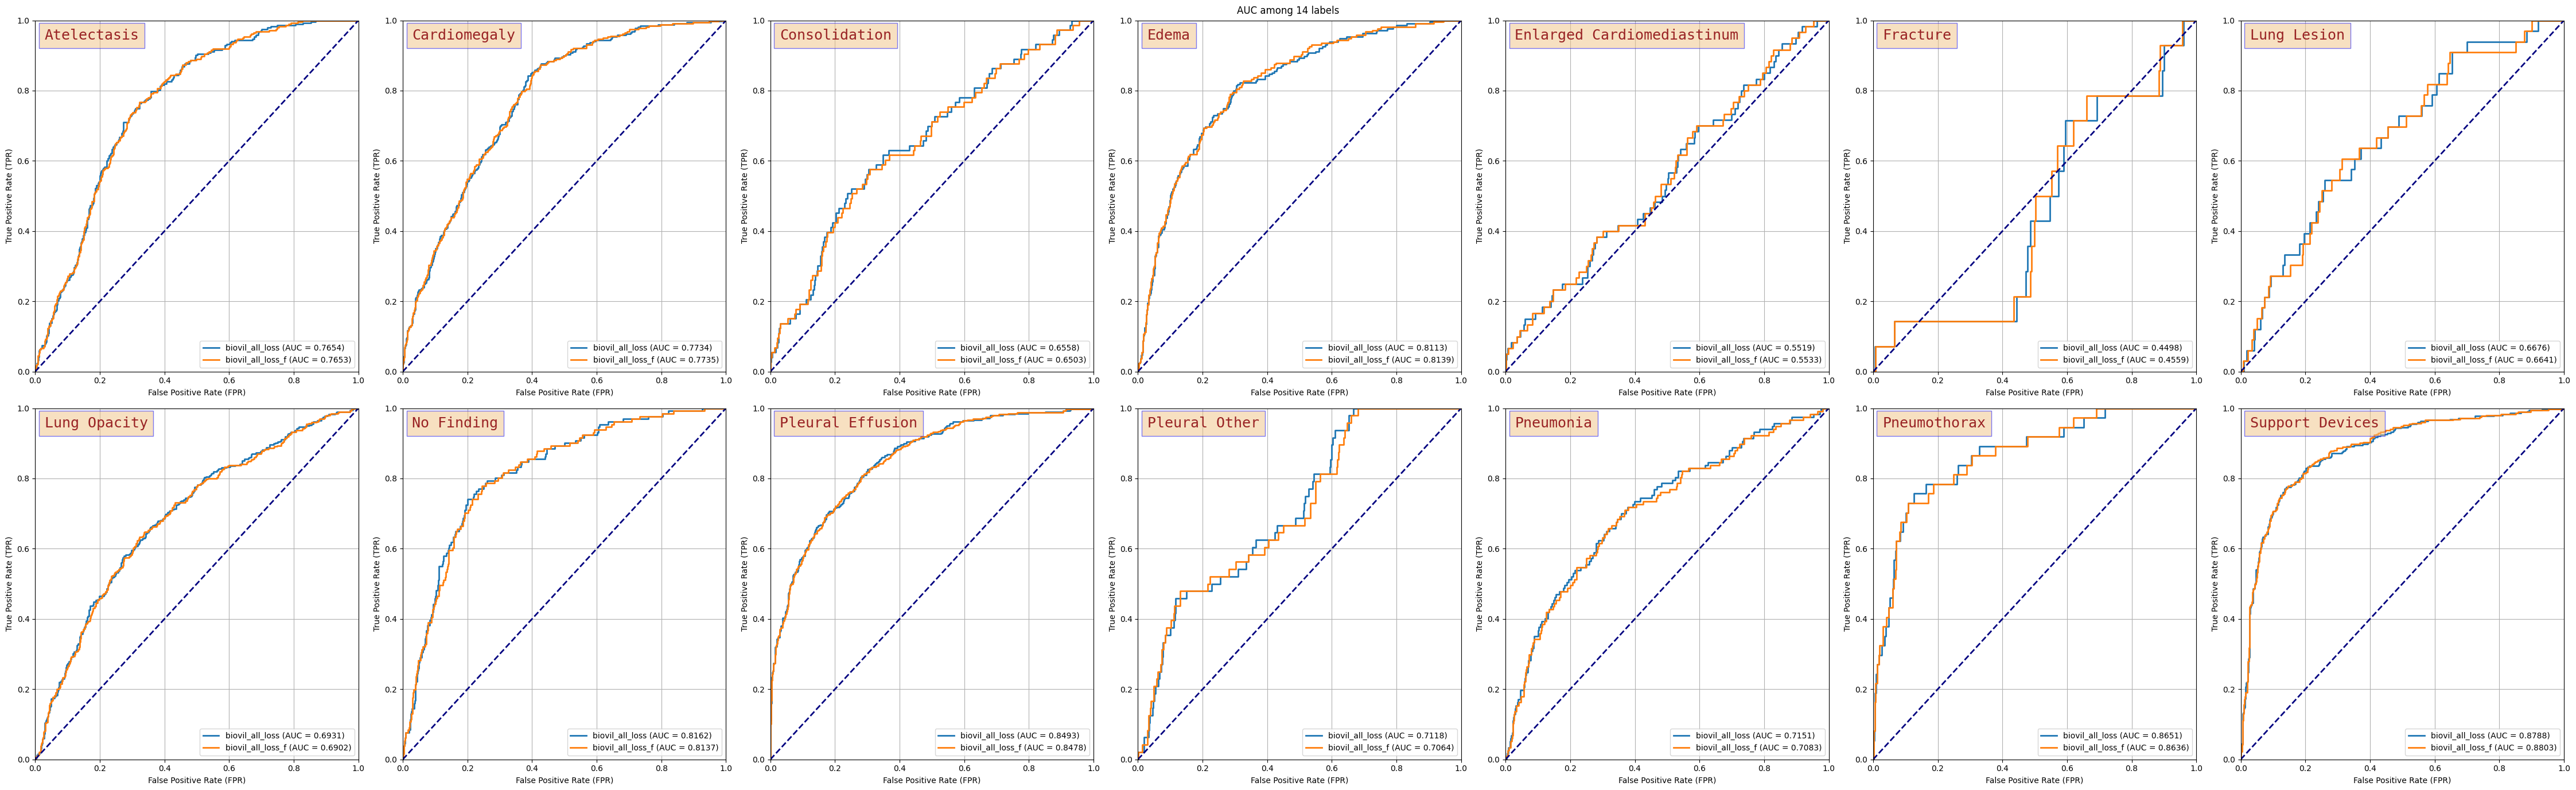

In [24]:
data = { "biovil_all_loss_f":{'predict': biovil_all_loss_f["predictions"], 'labels':biovil_all_loss_f["labels"]},
        "biovil_all_loss":{"predict":biovil_all_loss["predictions"], "labels": biovil_all_loss["labels"]}

}
fig, axs = plt.subplots(2, 7, figsize=(45, 14))
_,_, diff = print_roc(
          data = data , box = True, plot=False)
plt.suptitle('AUC among 14 labels')

# 调整布局，防止子图重叠
plt.tight_layout()

# 显示图形
plt.show()

<font type=Sylfaen color=#C3A060>using biovil_t as the backbone of the whole pipeline</font><br>
<font color=#e27055>
<b>Fracture</b> get a poor performance in this configuration (biovil + all_loss)</font><br>

<b>biovil_t_all_loss <font color=red>VS</font> biovil_t_vision_only</b>

[-0.00409212632112721, 0.006077518695815409, -0.0006339656415483841, 0.002853682170542493, 0.04787742899850522, 0.02042574135597386, -0.020909621610146978, -0.007114573190522444, -0.005447339943259855, 0.0013599480688086807, 0.02735876959479444, -0.006761669332557729, -0.004488671448249493, 0.005592068927427363]
biovil_v V.S. biovil_all_loss 
(biovil_v) - (biovil_all_loss)
total diff: 0.062097190324455376 
avg diff:  0.004435513594603956
biovil_v average auc = 0.7333457534262967
biovil_all_loss average auc = 0.7289102398316928


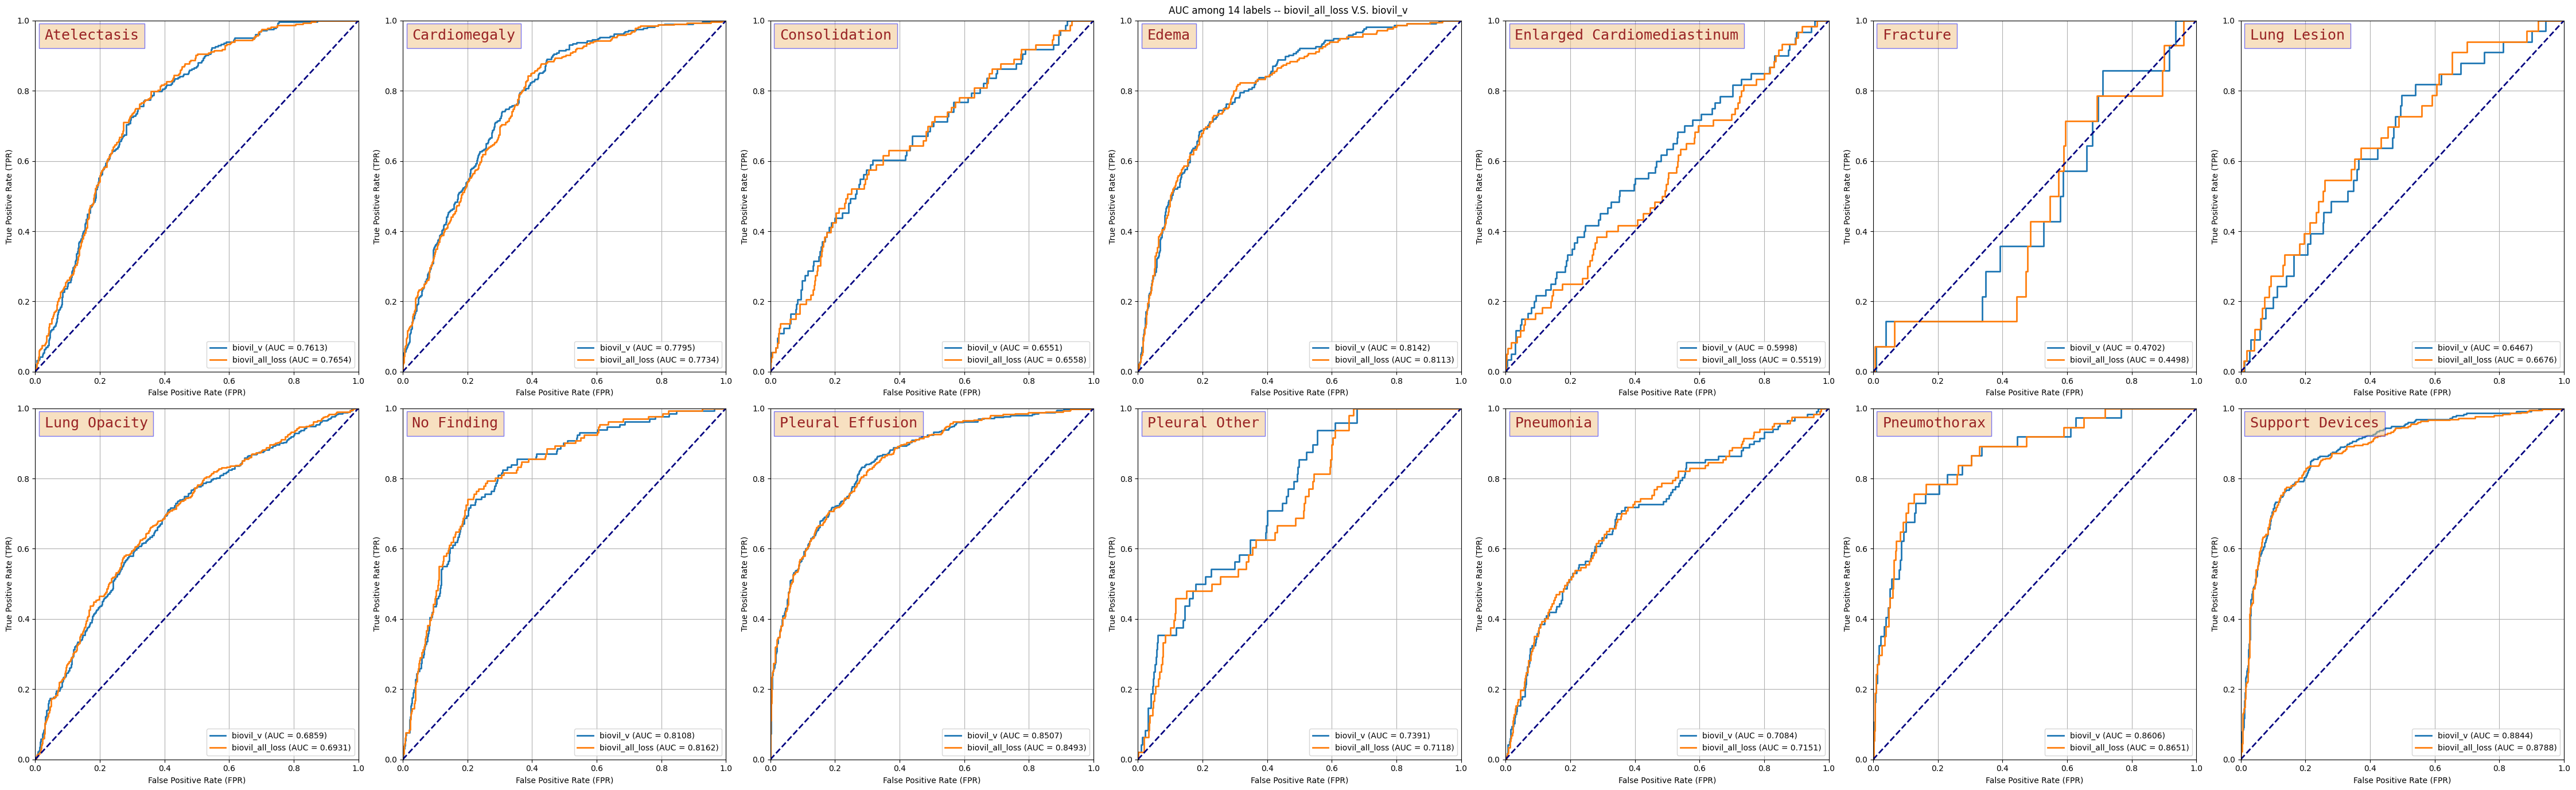

In [30]:
data = { "biovil_all_loss":{'predict': biovil_all_loss["predictions"], 'labels':biovil_all_loss["labels"]},
        "biovil_v":{"predict":biovil_v["predictions"], "labels": biovil_v["labels"]}

}
fig, axs = plt.subplots(2, 7, figsize=(45, 14))
_,_, diff = print_roc(
          data = data , box = True, plot=False)
plt.suptitle('AUC among 14 labels -- biovil_all_loss V.S. biovil_v')

# 调整布局，防止子图重叠
plt.tight_layout()

# 显示图形
plt.show()


from the plot above, <font color=red><b>vision only version</b></font> reach a <font color=green>better</font> performance in this task, compared with <font color=red><b>all loss version</b></font> --> (<font color=yellow>version > all_loss</font>)

Compared with BiomedCLIP, the average ROCs of them among 14 classes are closed. While BiomedCLIP get less variance among the performance of 14 classes.
1. Biomed is specified for Biomed rather than for x-ray, which is more general. From this consideration, this property may explain the better generalizability  while modifiing the embedding space.   
2. Biovil-t is specified for x-ray, which may lead to the poorer performance while I customized the embedding representation of diseases 

Biovil-T: Static & temporal pretraining for the CXR domain. As a both-edged sword, good performance in specificity weaken the performance in generalizability.

[-0.0013627216403366837, 0.004198745523666836, -0.0005966735449867144, 0.0021366279069765515, 0.03875934230194311, 0.03494524424756984, -0.004112933184736933, -0.0042453748782862455, -0.0052499195694772904, 0.0004414151249593212, 0.014880952380952328, -0.009136735979836108, -0.0007599867002328065, 0.00316883905887555]
biovil_v V.S. biovil_graph_only 
(biovil_v) - (biovil_graph_only)
total diff: 0.07306682104705076 
avg diff:  0.005219058646217911
biovil_v average auc = 0.7333457534262967
biovil_graph_only average auc = 0.7281266947800787


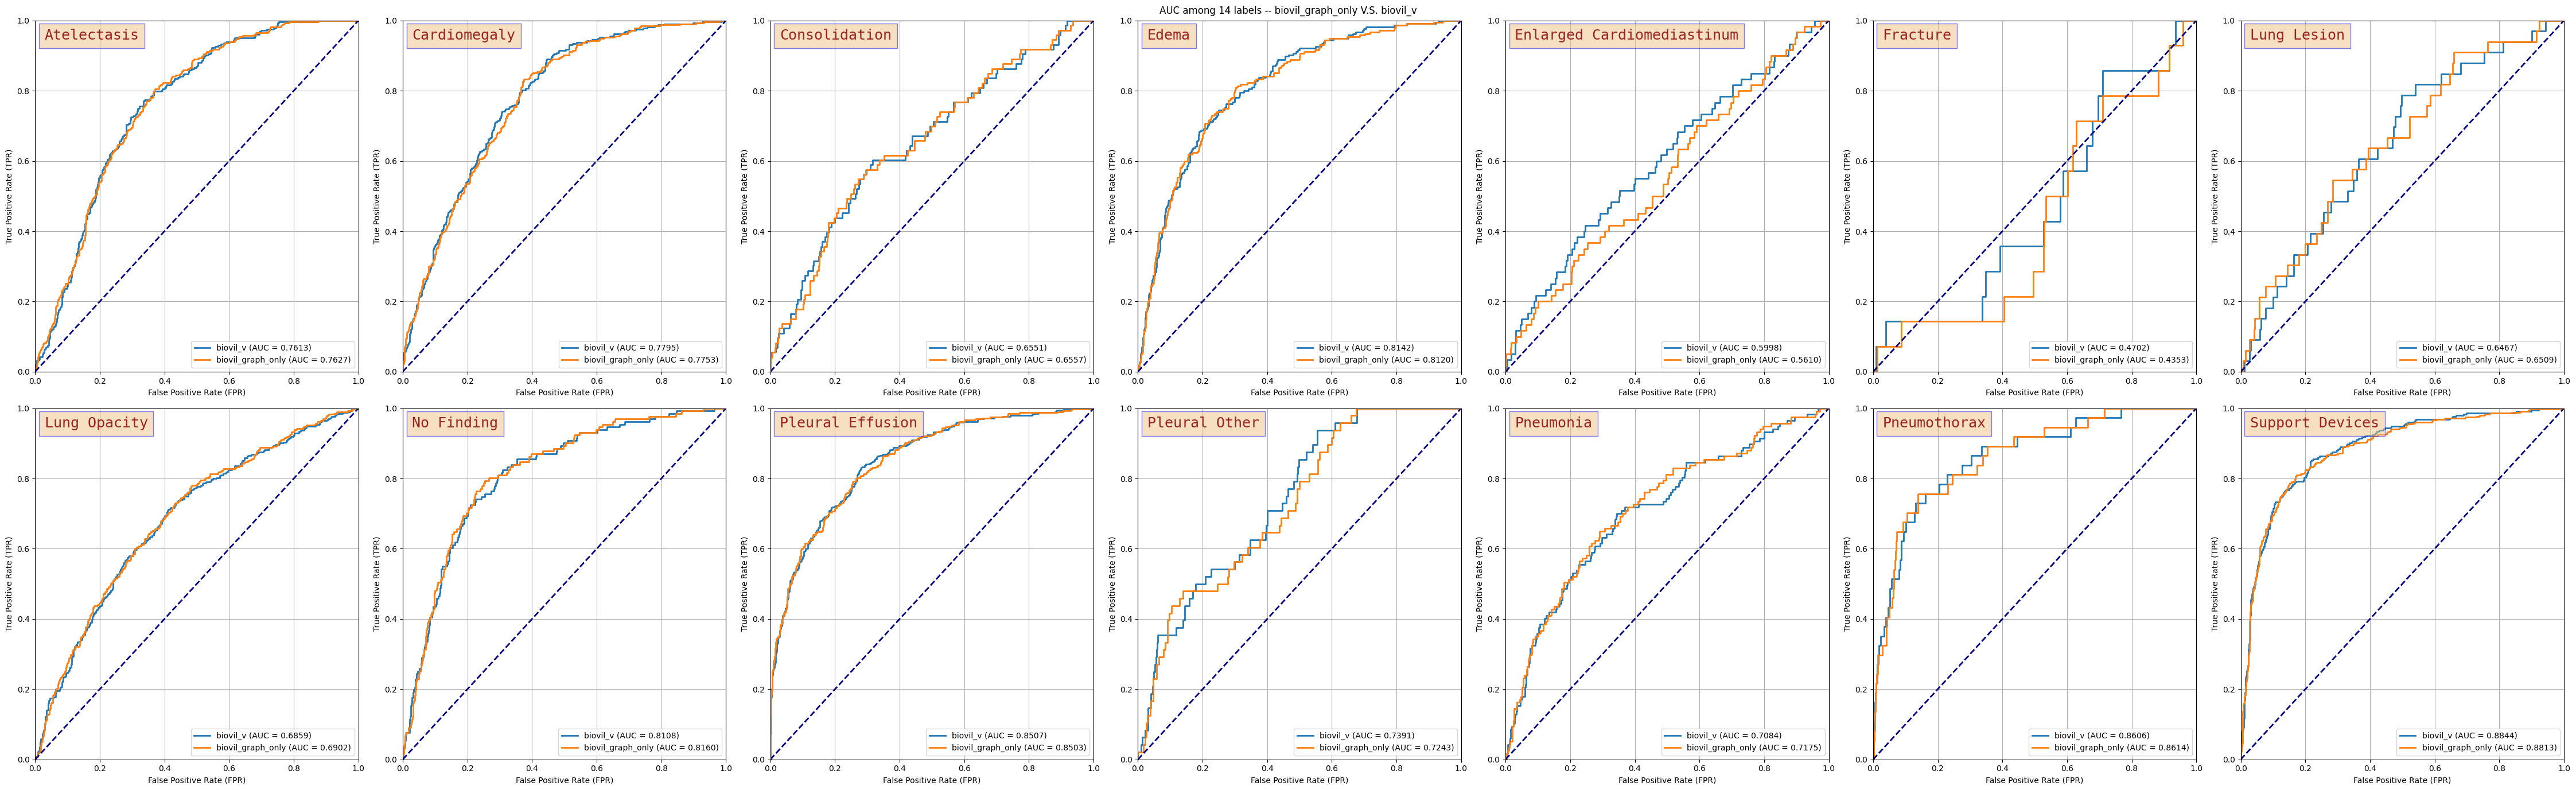

In [33]:
data = { "biovil_graph_only":{'predict': biovil_graph_only["predictions"], 'labels':biovil_graph_only["labels"]},
        "biovil_v":{"predict":biovil_v["predictions"], "labels": biovil_v["labels"]}

}
fig, axs = plt.subplots(2, 7, figsize=(45, 14))
_,_, diff = print_roc(
          data = data , box = True, plot=False)
plt.suptitle('AUC among 14 labels -- biovil_graph_only V.S. biovil_v')

# 调整布局，防止子图重叠
plt.tight_layout()

# 显示图形
plt.show()

even using the best configuration in biomedclip setting, the performance of this configuration is still quite limited.

----